<a href="https://colab.research.google.com/github/yahwanth/STIMULATING-INSOLVECY-AND-LOAN-ELIGIBILTY/blob/main/Stimulating_the_insolvency_and_loan_eligibility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import re
import warnings
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import arima_model
from statsmodels.graphics.api import qqplot

In [ ]:
def cleanColumnName(column):
    column = re.sub('\W+',' ', column.strip())                     #Remove all symbols from the column name
    column = column.strip()                                        #Remove all whitespaces from the ends of the column name
    return column.lower().replace(" ","_")                         #Replace spaces in between words with '_'

def dateParse(dates):
    pd.datetime.strptime(dates, '%Y-%m-%d')

def test_stationarity(ticker, timeseries):
    
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=7, center=False).mean()
    rolstd = timeseries.rolling(window=7, center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(ticker)
    plt.show(block=False)
    
    #Durbin-Watson Statistic for Autocorrelation
    dftest = durbin_watson(timeseries)
    print(ticker)
    print("Durbin-Watson statistic for "+ticker+": ",dftest)

warnings.filterwarnings('ignore')

In [ ]:
bankrupt_companies = pd.read_csv("/content/drive/MyDrive/bankruptcy/public_company_bankruptcy_cases_2011.csv")
companies_stock_prices = pd.read_csv("/content/drive/MyDrive/bankruptcy/prices-split-adjusted.csv", parse_dates=True, usecols=["date","symbol","close"], date_parser=dateParse)
nyse_data = pd.read_csv("/content/drive/MyDrive/bankruptcy/fundamentals.csv", index_col='Unnamed: 0')

# DATA CLEANING: Removing unnecessary columns from the datasets. This is completely heuristic, since we
# are dropping the columns based purely on our own understanding of their significance.
bankrupt_companies.drop(["DISTRICT", "STATE", "COMPANY NAME"], axis=1, inplace=True)
nyse_data.drop(["Deferred Asset Charges","Deferred Liability Charges","Depreciation","Earnings Before Tax","Effect of Exchange Rate","Equity Earnings/Loss Unconsolidated Subsidiary","Goodwill","Income Tax","Intangible Assets","Interest Expense","Liabilities","Minority Interest","Misc. Stocks","Net Cash Flow-Operating","Net Cash Flows-Financing","Net Cash Flows-Investing","Net Income Adjustments","Net Income Applicable to Common Shareholders","Net Income-Cont. Operations","Operating Income","Operating Margin","Other Assets","Other Current Assets","Other Current Liabilities","Other Financing Activities","Other Investing Activities","Other Liabilities","Other Operating Activities","Other Operating Items","Pre-Tax Margin","Pre-Tax ROE","Research and Development","Total Current Assets","Total Current Liabilities","Total Liabilities & Equity","Treasury Stock", "For Year"], axis=1, inplace=True)

# DATA CLEANING: Making Column Name Formats Consistent
bankrupt_companies.columns = map(cleanColumnName, bankrupt_companies.columns)
bankrupt_companies.columns = ["total_assets", "total_liabilities"]
companies_stock_prices.columns = map(cleanColumnName, companies_stock_prices.columns)
nyse_data.columns = map(cleanColumnName, nyse_data.columns)

nyse_data.head()

,ticker_symbol,period_ending,accounts_payable,accounts_receivable,add_l_income_expense_items,after_tax_roe,capital_expenditures,capital_surplus,cash_ratio,cash_and_cash_equivalents,changes_in_inventories,common_stocks,cost_of_revenue,current_ratio,earnings_before_interest_and_tax,fixed_assets,gross_margin,gross_profit,inventory,investments,long_term_debt,long_term_investments,net_borrowings,net_cash_flow,net_income,net_receivables,non_recurring_items,other_equity,profit_margin,quick_ratio,retained_earnings,sale_and_purchase_of_stock,sales_general_and_admin,short_term_debt_current_portion_of_long_term_debt,short_term_investments,total_assets,total_equity,total_liabilities,total_revenue,earnings_per_share,estimated_shares_outstanding
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,1.049900e+10,78.0,-1.813000e+09,1.340200e+10,58.0,1.435600e+10,5.800000e+08,3.060000e+08,7.116000e+09,0.0,-1.020000e+09,197000000.0,-1.876000e+09,1.124000e+09,3.860000e+08,-2.980000e+09,8.0,72.0,-9.462000e+09,0.000000e+00,1.297700e+10,1.419000e+09,3.412000e+09,2.351000e+10,-7.987000e+09,2.489100e+10,2.485500e+10,-5.60,3.350000e+08
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,1.101900e+10,104.0,-1.324000e+09,1.925900e+10,59.0,1.572400e+10,1.012000e+09,-1.181000e+09,1.535300e+10,0.0,2.208000e+09,660000000.0,-1.834000e+09,1.560000e+09,5.590000e+08,-2.032000e+09,7.0,96.0,-1.129600e+10,0.000000e+00,1.291300e+10,1.446000e+09,8.111000e+09,4.227800e+10,-2.731000e+09,4.500900e+10,2.674300e+10,-11.25,1.630222e+08
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,1.562000e+10,88.0,4.099000e+09,2.308400e+10,63.0,2.703000e+10,1.004000e+09,1.799000e+09,1.604300e+10,0.0,1.700000e+08,-146000000.0,2.882000e+09,1.771000e+09,8.000000e+08,-4.559000e+09,7.0,80.0,-8.562000e+09,-1.052000e+09,2.068600e+10,1.677000e+09,6.309000e+09,4.322500e+10,2.021000e+09,4.120400e+10,4.265000e+10,4.02,7.169154e+08
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,6000000.0,1.109600e+10,73.0,5.496000e+09,2.751000e+10,73.0,2.989400e+10,8.630000e+08,4.430000e+08,1.833000e+10,0.0,2.856000e+09,-604000000.0,7.610000e+09,1.425000e+09,1.051000e+09,-4.732000e+09,19.0,67.0,-1.230000e+09,-3.846000e+09,2.127500e+10,2.231000e+09,5.864000e+09,4.841500e+10,5.635000e+09,4.278000e+10,4.099000e+10,11.39,6.681299e+08
4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,-260298000.0,7000.0,3.106967e+09,124.0,6.579150e+08,1.292547e+09,50.0,3.098036e+09,2.308609e+09,0.000000e+00,6.044610e+08,0.0,1.774450e+08,540210000.0,3.876700e+08,2.298660e+08,0.000000e+00,2.667000e+06,6.0,34.0,7.149000e+08,-1.860000e+07,2.440721e+09,6.270000e+05,0.000000e+00,4.613814e+09,1.210694e+09,3.403120e+09,6.205003e+09,5.29,7.328355e+07


In [ ]:
# Remove NaN values from respective datasets
bankrupt_companies.dropna(axis=0, subset=['total_assets', 'total_liabilities'], inplace=True)

nyse_data.dropna(axis=1, how='any', inplace=True)
nyse_data.dropna(axis=0, how='any', inplace=True)

companies_stock_prices.dropna(axis=0, how='any', inplace=True)

##**Preparing SVM to work as Insolvency Predictor:**



In [ ]:
# Create new dataframe containing data of non-bankrupt companies in 2013
nyse_2013 = nyse_data.loc[nyse_data['period_ending'].str.contains("2013"), ["total_assets", "total_liabilities"]]

# Randomly sample this dataset to get a dataframe containing the data for as many non-bankrupt companies 
# as there are bankrupt companies in the other dataset
nyse_2013 = nyse_2013.sample(n=bankrupt_companies.shape[0], replace=False)

# Assign indexes to the 2013 NYSE dataframe to start after the last index of the bankrupt_companies 
# dataframe to ease the merge operation
nyse_2013.set_index([[x for x in range(bankrupt_companies.index[-1]+1, bankrupt_companies.index[-1]+nyse_2013.shape[0]+1)]], inplace=True)

# Manually adding the column "bankrupt" to the dataset to be used as label 
bankrupt_companies["stability"] = 0
nyse_2013["stability"] = 1

# Merge the bankruptcy and non-bankruptcy dataframes to generate one that can be used for training a classifier.
merged_bankruptcy_dataset = pd.concat([bankrupt_companies, nyse_2013])

merged_bankruptcy_dataset[["total_assets", "total_liabilities"]].dtypes
merged_bankruptcy_dataset["total_assets"] = pd.to_numeric(merged_bankruptcy_dataset["total_assets"],errors = 'coerce')
merged_bankruptcy_dataset["total_liabilities"] = pd.to_numeric(merged_bankruptcy_dataset["total_liabilities"],errors = 'coerce')
merged_bankruptcy_dataset[["total_assets", "total_liabilities"]].dtypes

# Scaling the data to ensure assets and liabilities are in equivalent ranges
scaler = pp.MinMaxScaler()
scaler.fit(merged_bankruptcy_dataset[["total_assets", "total_liabilities"]])
merged_bankruptcy_dataset[["total_assets", "total_liabilities"]] = scaler.transform(merged_bankruptcy_dataset[["total_assets", "total_liabilities"]])

# Randomly Splitting the merged dataset into training and test datasets for training the Decision Tree
train_bankruptcy_data, test_bankruptcy_data, train_bankruptcy_target, test_bankruptcy_target = train_test_split(
    merged_bankruptcy_dataset.iloc[:,0:-1], merged_bankruptcy_dataset.iloc[:,-1], 
    test_size=0.2
)

In [ ]:
train_bankruptcy_data.isnull().sum()

total_assets         9
total_liabilities    7
dtype: int64

In [ ]:
train_bankruptcy_target.isnull().sum()



0

In [ ]:
train_bankruptcy_data.fillna((train_bankruptcy_data.mean()), inplace=True)

In [ ]:
test_bankruptcy_data.isnull().sum()

total_assets         0
total_liabilities    0
dtype: int64

In [ ]:
test_bankruptcy_data.fillna((test_bankruptcy_data.mean()), inplace=True)

(99, 2) 0.7272727272727273
(25, 2) 0.8


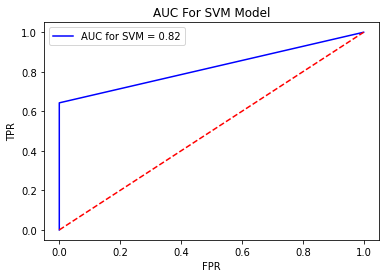

In [ ]:
#Training SVM on the training data
Svm_model = svm.LinearSVC()
Svm_model.fit(train_bankruptcy_data, train_bankruptcy_target)

print(train_bankruptcy_data.shape, Svm_model.score(train_bankruptcy_data, train_bankruptcy_target))
print(test_bankruptcy_data.shape, Svm_model.score(test_bankruptcy_data, test_bankruptcy_target))

# Calculating and plotting the ROC and Area-under-curve to understand the classifier accuracy
FPR, TPR, _ = metrics.roc_curve(test_bankruptcy_target, Svm_model.predict(test_bankruptcy_data))
auc = metrics.auc(FPR, TPR)

plt.plot(FPR, TPR, 'b', label = 'AUC for SVM = %0.2f' %auc)
plt.title("AUC For SVM Model")
plt.legend(loc='best')
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

In [ ]:
# Keep only the data for the last year for all companies. We shall be taking only latest data into consideration.
nyse_data.drop_duplicates(subset='ticker_symbol', keep='last', inplace=True)

# Adding in the predicted values for bankruptcy in the original dataset
nyse_data["stability"] = Svm_model.predict(scaler.transform(nyse_data[["total_assets", "total_liabilities"]]))
print("Companies predicted to go bankrupt over a 4 year period: ", len(nyse_data.loc[nyse_data["stability"] != 1, "ticker_symbol"]))

Companies predicted to go bankrupt over a 4 year period:  198


### **TIME SERIES ANALYSIS**

In [ ]:
companies_stock_prices["date"]

0         2016-01-05
1         2016-01-06
2         2016-01-07
3         2016-01-08
4         2016-01-11
             ...    
851259    2016-12-30
851260    2016-12-30
851261    2016-12-30
851262    2016-12-30
851263    2016-12-30
Name: date, Length: 851264, dtype: object

In [ ]:
import io

#companies_stock_prices['year'],companies_stock_prices['month'],companies_stock_prices['day'] = companies_stock_prices.date.dt.year, companies_stock_prices.date.dt.month, companies_stock_prices.date.dt.day

companies_stock_prices["date"] = pd.to_datetime(companies_stock_prices["date"], infer_datetime_format=True,errors='coerce')
companies_stock_prices.dropna(axis=0, how='any', inplace=True)

# Sorting by ticker symbol
companies_stock_prices.sort_values(by=["symbol", "date"], inplace=True)

# Assuming that the stock trend for each company is distinct, we shall need to model different
# time series for each company by storing the data for each in separate keys in a dictionary.
weekly_stock_prices = {}            # Dictionary to store weekly stock prices for each company

# Add data for each company into separate keys in the dictionary so that time series analysis
# can be run separately for each company.
for i in np.unique(companies_stock_prices["symbol"].values):
    weekly_stock_prices[i] = companies_stock_prices.loc[companies_stock_prices["symbol"] == i, :].copy()
    weekly_stock_prices[i] = weekly_stock_prices[i].reset_index(drop=True)

In [ ]:
weekly_stock_prices

{'A':            date symbol      close
 0    2010-01-04      A  22.389128
 1    2010-01-05      A  22.145923
 2    2010-01-06      A  22.067240
 3    2010-01-07      A  22.038626
 4    2010-01-08      A  22.031474
 ...         ...    ...        ...
 1757 2016-12-23      A  46.200001
 1758 2016-12-27      A  46.509998
 1759 2016-12-28      A  45.720001
 1760 2016-12-29      A  45.639999
 1761 2016-12-30      A  45.560001
 
 [1762 rows x 3 columns], 'AAL':            date symbol      close
 0    2010-01-04    AAL   4.770000
 1    2010-01-05    AAL   5.310000
 2    2010-01-06    AAL   5.090000
 3    2010-01-07    AAL   5.240000
 4    2010-01-08    AAL   5.140000
 ...         ...    ...        ...
 1757 2016-12-23    AAL  48.480000
 1758 2016-12-27    AAL  48.610001
 1759 2016-12-28    AAL  47.669998
 1760 2016-12-29    AAL  47.250000
 1761 2016-12-30    AAL  46.689999
 
 [1762 rows x 3 columns], 'AAP':            date symbol       close
 0    2010-01-04    AAP   40.380001
 1    2010-01-0

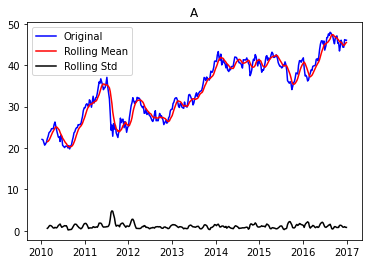

A
Durbin-Watson statistic for A:  [0.00082012]


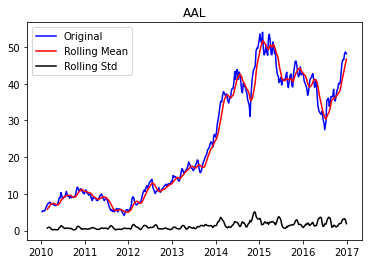

AAL
Durbin-Watson statistic for AAL:  [0.00212219]


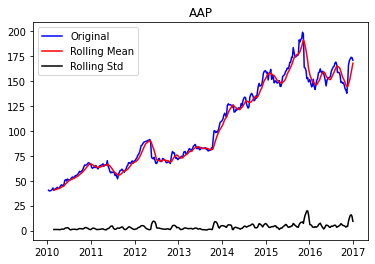

AAP
Durbin-Watson statistic for AAP:  [0.0010451]


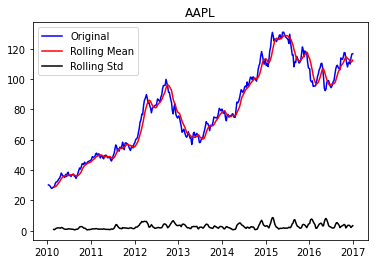

AAPL
Durbin-Watson statistic for AAPL:  [0.00082069]


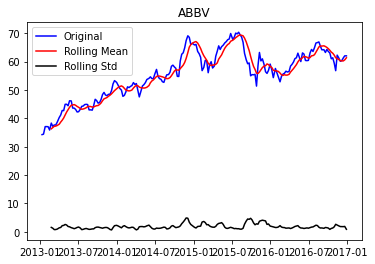

ABBV
Durbin-Watson statistic for ABBV:  [0.00093193]


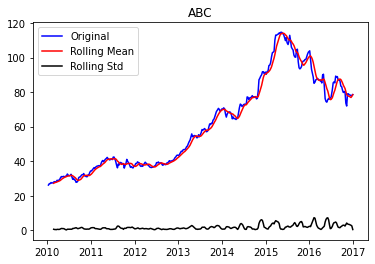

ABC
Durbin-Watson statistic for ABC:  [0.00060559]


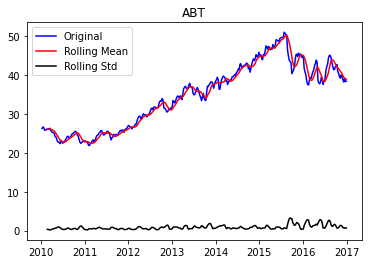

ABT
Durbin-Watson statistic for ABT:  [0.00046642]


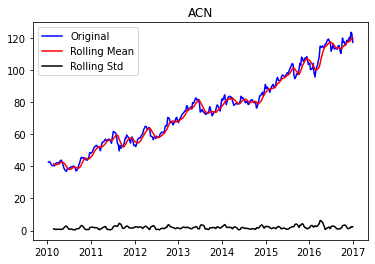

ACN
Durbin-Watson statistic for ACN:  [0.00054152]


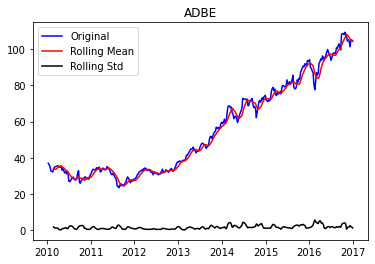

ADBE
Durbin-Watson statistic for ADBE:  [0.00074189]


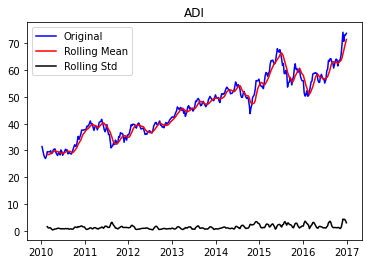

ADI
Durbin-Watson statistic for ADI:  [0.00073023]


In [ ]:
 count = 0
for i in weekly_stock_prices:
    weekly_mean = weekly_stock_prices[i]["close"].rolling(window=5, center=False).mean()[4:]
    # Convert the daily stock data to weekly by keeping only the data for one day a week
    weekly_stock_prices[i] = weekly_stock_prices[i].loc[weekly_stock_prices[i].index % 5 == 0, :]
    weekly_stock_prices[i]["close"] = weekly_mean
    weekly_stock_prices[i].index = weekly_stock_prices[i]["date"]
    weekly_stock_prices[i].drop(["symbol", "date"], axis=1, inplace=True)
    weekly_stock_prices[i].dropna(axis=0, how='any', inplace=True)
    
    count += 1
    # Showing only the first 10 plots since there are ~450 companies, and plotting them all would
    # take a lot of time. Trend and seasonality can be assumed to be present in all of them.
    if count <= 10:
        test_stationarity(i, weekly_stock_prices[i])

####**As can be expected, stock prices data shows an easily visible trend, and closer inspection reveals the presence of seasonality as well in many cases. The low Durbin-Watson statistic value is evidence of high positive autocorrelation, which is also understandable since stock prices are dependent on previous values. Thus, to run ARIMA analysis on this data, we need to perform operations on it to make it stationary first.**

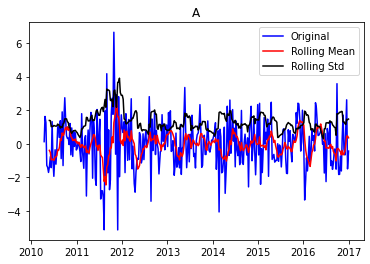

A
Durbin-Watson statistic for A:  1.8770268065052182


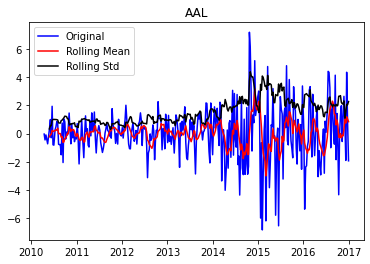

AAL
Durbin-Watson statistic for AAL:  1.6537317417868205


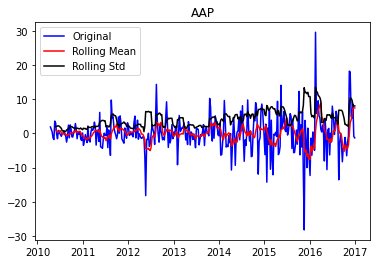

AAP
Durbin-Watson statistic for AAP:  1.6198291714072184


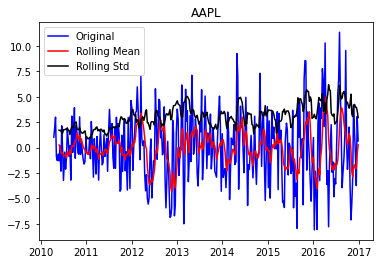

AAPL
Durbin-Watson statistic for AAPL:  1.4553815901058087


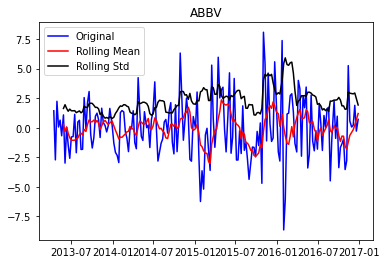

ABBV
Durbin-Watson statistic for ABBV:  1.8224304701510499


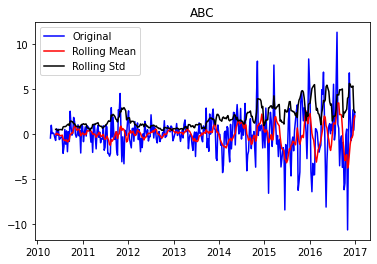

ABC
Durbin-Watson statistic for ABC:  1.3236146242469047


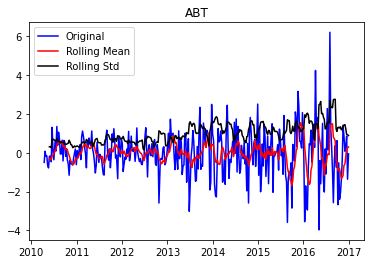

ABT
Durbin-Watson statistic for ABT:  1.4996659516838393


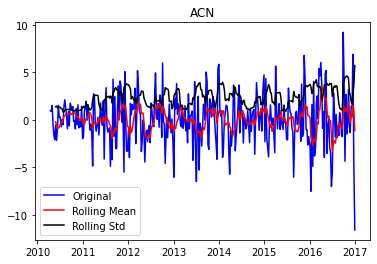

ACN
Durbin-Watson statistic for ACN:  1.7232374331031954


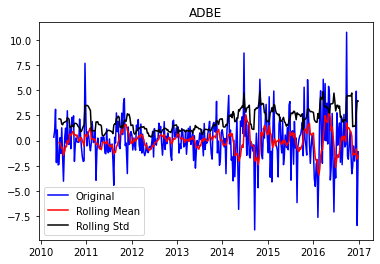

ADBE
Durbin-Watson statistic for ADBE:  1.8407997273561738


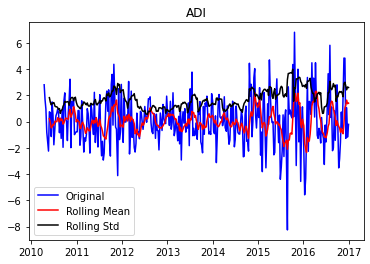

ADI
Durbin-Watson statistic for ADI:  1.680963580821613


In [ ]:
count = 0
weekly_stock_prices_log = {}
for i in weekly_stock_prices:
    # Using Differencing to remove Trend and Seasonality in the data
    weekly_stock_prices_log[i] = weekly_stock_prices[i].copy()
    weekly_stock_prices_log[i]["first_difference"] = weekly_stock_prices_log[i]["close"] - weekly_stock_prices_log[i]["close"].shift(1)
    weekly_stock_prices_log[i]["seasonal_first_difference"] = weekly_stock_prices_log[i]["first_difference"] - weekly_stock_prices_log[i]["first_difference"].shift(12)

    count += 1
    if count <=10:
        test_stationarity(i, weekly_stock_prices_log[i]["seasonal_first_difference"].dropna(inplace=False))

####**The plots can now be seen to have lost the trend and seasonality that was present in the previous plots. The Durbin-Watson statistic too shows a value ~2, and thus we can conclude that the residuals are stationary and can proceed to perform analysis operations on them.**

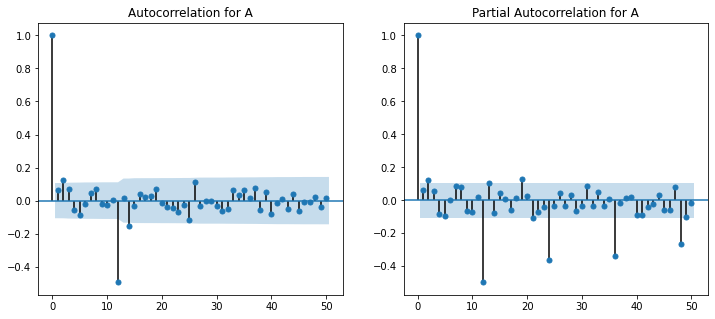

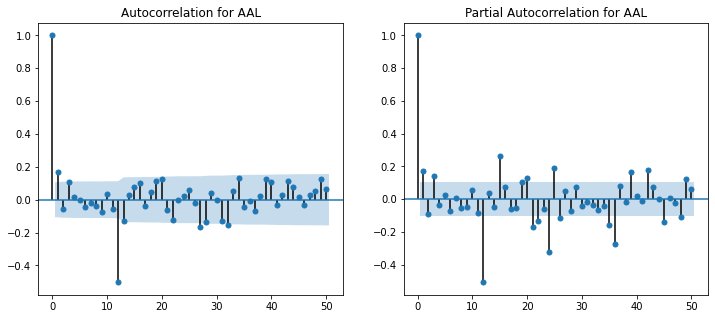

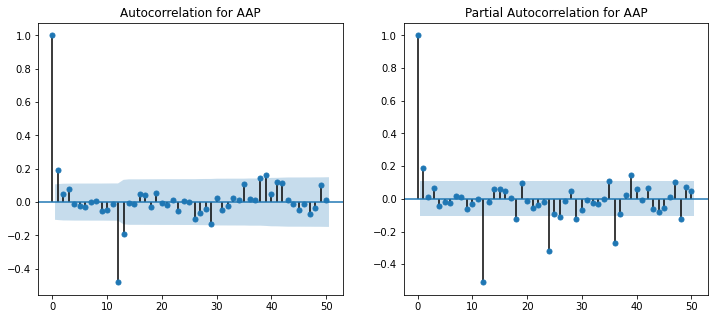

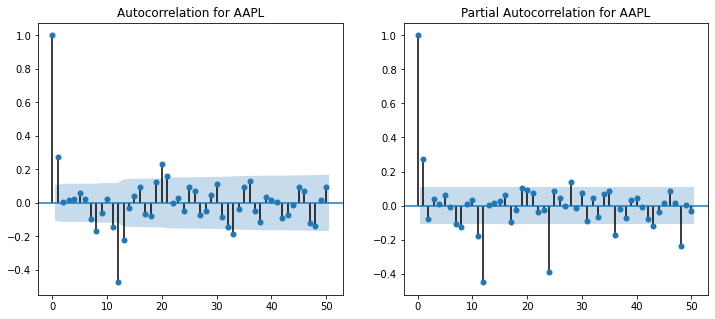

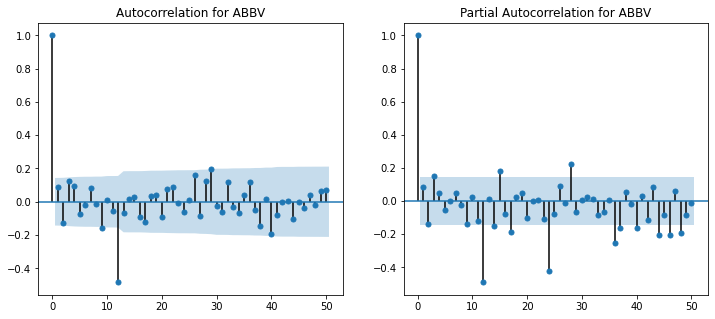

In [ ]:
# Decide the Autoregression and Moving Average Parameters by plotting ACF and PACF plots.
count = 0
for i in weekly_stock_prices_log:
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)
    plot_acf(weekly_stock_prices_log[i]["seasonal_first_difference"].iloc[13:], lags=50, title="Autocorrelation for "+i, ax=ax1)
    ax2 = fig.add_subplot(122)
    plot_pacf(weekly_stock_prices_log[i]["seasonal_first_difference"].iloc[13:], lags=50, title="Partial Autocorrelation for "+i, ax=ax2)
    count += 1
    if count == 5:
        break
plt.show()

####**The ACF and PACF plots show a spike at lag 1. The plots are not conclusive themselves however, since none can be said to be exponentially decreasing, as well as showing a number of outliers. Trials using different values for p and q showed significantly better results at (2,1)**.

####**An ACF-PACF analysis for all companies was not possible, hence for instances where the SVD did not converge for (2,1), a fallback value of (1,0) was used.**

For A:  NormaltestResult(statistic=285.36625970181507, pvalue=1.0801996819315473e-62)


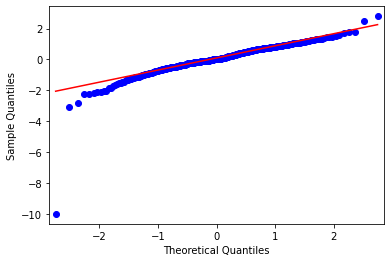

For AAL:  NormaltestResult(statistic=289.0327601710137, pvalue=1.7271640278067375e-63)


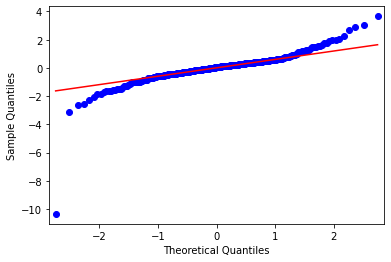

For AAP:  NormaltestResult(statistic=489.2686049310352, pvalue=5.71047658321053e-107)


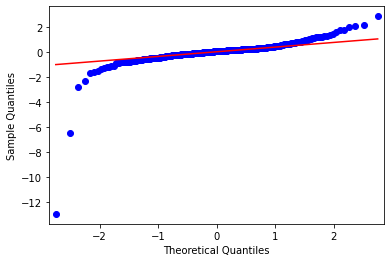

For AAPL:  NormaltestResult(statistic=457.83624701369934, pvalue=3.820517148159447e-100)


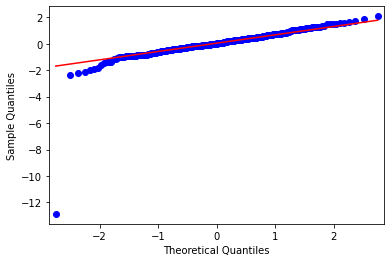

For ABBV:  NormaltestResult(statistic=174.32376931206855, pvalue=1.3998273082173028e-38)


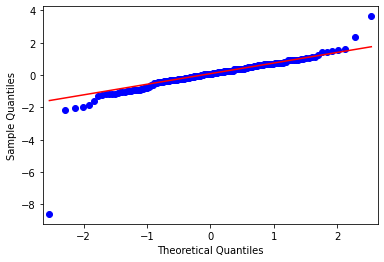

In [ ]:
from scipy import stats
count = 0
stock_predictions = {}
for i in weekly_stock_prices_log:
    # Splitting available data into training for accuracy check using remaining data points
    split_point = len(weekly_stock_prices_log[i]) - 20
    # Number of weeks from last date in dataset to 2018-12-31 = 117
    num_of_predictions = len(weekly_stock_prices_log[i]) + 117
    training = weekly_stock_prices_log[i][0:split_point]
    model = {}
    # Try modelling first using p=2, q=1, if that fails use p=1, q=0
    try:
        model = arima_model.ARMA(training["close"], order=(2,1)).fit()
    except:
        model = arima_model.ARMA(training["close"].astype(float), order=(1,0)).fit()
    
    #Add the predicted values in a dataframe for ease of further operations.
    daterange = pd.date_range(training.index[0], periods=num_of_predictions, freq = 'W-MON').tolist()
    stock_predictions[i] = pd.DataFrame(columns=["date", "prediction"])
    stock_predictions[i]["date"] = daterange
    stock_predictions[i]["prediction"] = model.predict(start=0, end=num_of_predictions)
    stock_predictions[i].set_index("date", inplace=True)
    
    # Draw a QQPlot to check if the residuals are evenly distributed
    if count < 5:
        resid = model.resid
        print("For "+i+": ",stats.normaltest(resid))
        qqplot(resid, line='q', fit=True)
        plt.show()
        count += 1


####**The QQ plots show reasonably equal distribution, and we can thus conclude that the residuals analyzed were proper.**

In [ ]:
stock_predictions

{'A':             prediction
 date                  
 2010-01-11   33.861460
 2010-01-18   22.146216
 2010-01-25   22.041747
 2010-02-01   21.358079
 2010-02-08   20.687137
 ...                ...
 2018-12-03   37.199617
 2018-12-10   37.164778
 2018-12-17   37.130304
 2018-12-24   37.096189
 2018-12-31   37.062430
 
 [469 rows x 1 columns], 'AAL':             prediction
 date                  
 2010-01-11   20.808807
 2010-01-18    5.223346
 2010-01-25    5.579036
 2010-02-01    5.337428
 2010-02-08    5.497653
 ...                ...
 2018-12-03   27.569706
 2018-12-10   27.538241
 2018-12-17   27.506923
 2018-12-24   27.475750
 2018-12-31   27.444722
 
 [469 rows x 1 columns], 'AAP':             prediction
 date                  
 2010-01-11  103.619016
 2010-01-18   40.518580
 2010-01-25   39.675073
 2010-02-01   40.021193
 2010-02-08   40.409757
 ...                ...
 2018-12-03  153.241165
 2018-12-10  153.138947
 2018-12-17  153.036940
 2018-12-24  152.935143
 2018-12-31  152.

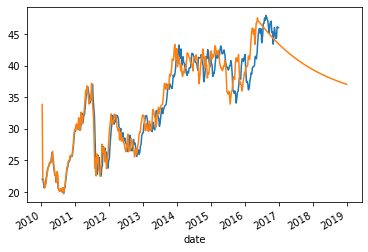

'Mean Absolute Error for A: 0.047314250836163634'

'Mean Forecast Error for A: 2.1729974015347033'

-------------------------------------------------------------------------------------------------------------------------


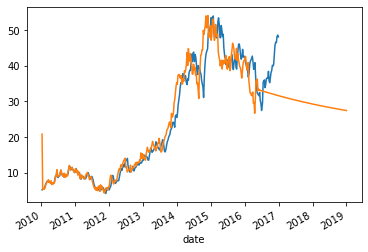

'Mean Absolute Error for AAL: 0.10250428625368684'

'Mean Forecast Error for AAL: 3.359424871689967'

-------------------------------------------------------------------------------------------------------------------------


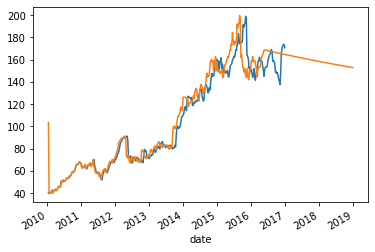

'Mean Absolute Error for AAP: 0.0344800577039239'

'Mean Forecast Error for AAP: -5.775438162782668'

-------------------------------------------------------------------------------------------------------------------------


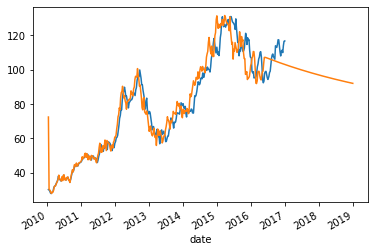

'Mean Absolute Error for AAPL: 0.02739159687581889'

'Mean Forecast Error for AAPL: 2.903218213990916'

-------------------------------------------------------------------------------------------------------------------------


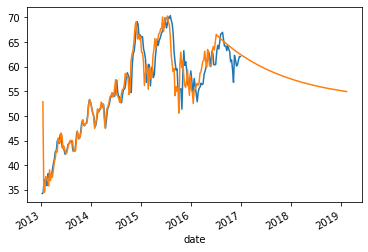

'Mean Absolute Error for ABBV: 0.03227699384295868'

'Mean Forecast Error for ABBV: -2.0931350109046987'

-------------------------------------------------------------------------------------------------------------------------


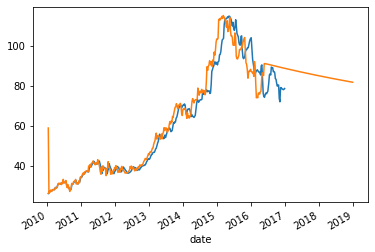

'Mean Absolute Error for ABC: 0.02029367600731858'

'Mean Forecast Error for ABC: -1.8334895167806498'

-------------------------------------------------------------------------------------------------------------------------


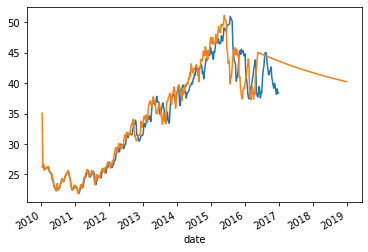

'Mean Absolute Error for ABT: 0.004415831449181866'

'Mean Forecast Error for ABT: -0.19695568670698313'

-------------------------------------------------------------------------------------------------------------------------


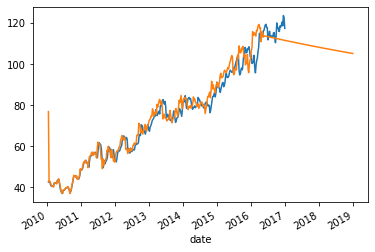

'Mean Absolute Error for ACN: 0.00918137454239069'

'Mean Forecast Error for ACN: 1.0371679664745177'

-------------------------------------------------------------------------------------------------------------------------


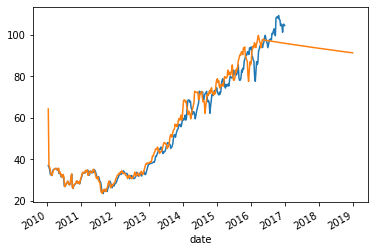

'Mean Absolute Error for ADBE: 0.04217966109811318'

'Mean Forecast Error for ADBE: 4.089258097396136'

-------------------------------------------------------------------------------------------------------------------------


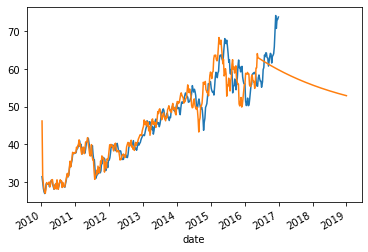

'Mean Absolute Error for ADI: 0.03640063724077388'

'Mean Forecast Error for ADI: 2.255110360264934'

-------------------------------------------------------------------------------------------------------------------------


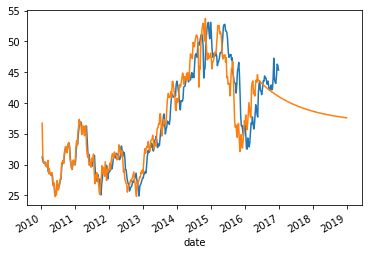

'Mean Absolute Error for ADM: 0.0254793813988947'

'Mean Forecast Error for ADM: 1.091014033846091'

-------------------------------------------------------------------------------------------------------------------------


In [ ]:
# Analysis of the Time Series model
count = 0
for i in weekly_stock_prices_log:
    # Plot actual values against predicted values
    weekly_stock_prices_log[i]["close"].plot()
    stock_predictions[i]["prediction"].plot()
    plt.show()
    
    # Calculate Mean Absolute Error and Mean Forecast Error for Validation data points
    split_point = len(weekly_stock_prices_log[i]) - 20
    forecastedValues = stock_predictions[i]["prediction"].iloc[split_point : len(weekly_stock_prices_log[i])]
    actualValues = weekly_stock_prices_log[i]["close"].iloc[split_point:]
    mfe = actualValues.subtract(forecastedValues).mean()
    mae = (abs(mfe)/forecastedValues).mean()
    display("Mean Absolute Error for "+i+": "+str(mae))
    display("Mean Forecast Error for "+i+": "+str(mfe))
    print( "-------------------------------------------------------------------------------------------------------------------------")
    count += 1
    if count > 10:
        break


####**Mean Absolute Error values ~0 show that the predictions made by the Time Series models had good accuracy.**

##**Augmenting the Initial Dataset with Predicted Data:**

In [ ]:
# Create new column to store the predicted stock prices
nyse_data["stock_pred"] = np.nan
for i in stock_predictions:
    # Calculating a percentage metric to estimate the rise or fall of the company's stock -- and
    # consequently the organization's growth -- in order to maintain a fair range across all organizations.
    perc=(stock_predictions[i]["prediction"].tail(105).mean() - stock_predictions[i]["prediction"].tail(105)[0])/stock_predictions[i]["prediction"].tail(105)[0]
    nyse_data.loc[nyse_data["ticker_symbol"] == i, "stock_pred"] = perc

# Add the predicted value of bankruptcy to the predicted stock price to generate a compounded
# label that effectively represents the growth or degeneration of the company.
nyse_data["stock_pred"] += nyse_data["stability"]

# Drop unnecessary and non-numerical columns from dataset for ease of modelling.
nyse_data.drop(["period_ending", "stability", "ticker_symbol"], axis=1, inplace=True)
nyse_data.dropna(axis=0, subset=["stock_pred"], inplace=True)

In [ ]:
# Scale the Features of the dataset
nyse_data_scaled = nyse_data.iloc[:,0:-1]
scaler = pp.StandardScaler()
nyse_data_scaled[nyse_data_scaled.columns] = scaler.fit_transform(nyse_data_scaled[nyse_data_scaled.columns])

# Scale the target variable to lie in between the values -1 and 1, rounded up to the nearest tenth place
# and multiplied by 10 to generate a non-continuous multi-valued label.
scaler = pp.MinMaxScaler(feature_range=(-1,1))
nyse_data_target_scaled = scaler.fit_transform(nyse_data.iloc[:,-1].values.reshape(-1,1)).round(decimals=1) * 10

# Split the augmented dataset into train and test sets for training the classifier.
train_data, test_data, train_target, test_target = train_test_split(nyse_data_scaled, nyse_data_target_scaled, test_size=0.3)

In [ ]:
# Training a Random Forest Classifier
RF = RandomForestClassifier()
RF.fit(train_data, train_target)

model_predictions = RF.predict(test_data)

print("Training:-->",train_data.shape, RF.score(train_data, train_target))
print("Testing:-->",test_data.shape, RF.score(test_data, test_target))

Training:--> (312, 34) 1.0
Testing:--> (135, 34) 0.7481481481481481


In [ ]:
# Analyze the features found by the Random Forest model to correlate most highly
# with the augmented label. Observe the numeric correlation.
top_features = np.argsort(RF.feature_importances_[-5:])
top_features = np.append(top_features, -1)
display(nyse_data.iloc[:, top_features].corr())


,accounts_payable,capital_expenditures,add_l_income_expense_items,after_tax_roe,accounts_receivable,stock_pred
accounts_payable,1.000000,-0.272466,0.108543,0.004480,0.496669,0.237398
capital_expenditures,-0.272466,1.000000,-0.354544,-0.012202,-0.055568,-0.308261
add_l_income_expense_items,0.108543,-0.354544,1.000000,-0.007567,0.029673,0.084972
after_tax_roe,0.004480,-0.012202,-0.007567,1.000000,0.001118,0.004228
accounts_receivable,0.496669,-0.055568,0.029673,0.001118,1.000000,0.022162
stock_pred,0.237398,-0.308261,0.084972,0.004228,0.022162,1.000000


In [ ]:
# Generate a Confusion Matrix and calculate the Matthews Correlation co-efficienct as
# evaluation metrics for the Random Forest classifier that was trained.
display("CONFUSION MATRIX: ",metrics.confusion_matrix(test_target, model_predictions))
display("MATTHEWS CORRELATION CO-EFFICIENT", metrics.matthews_corrcoef(test_target, model_predictions))

'CONFUSION MATRIX: '

array([[ 2,  6,  0,  0,  0,  0,  0,  0,  0],
       [ 3, 42,  0,  0,  0,  2,  0,  0,  0],
       [ 0,  6,  1,  0,  0,  1,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 56,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0]])

'MATTHEWS CORRELATION CO-EFFICIENT'

0.6193676211644734

Text(69.0, 0.5, 'Truth')

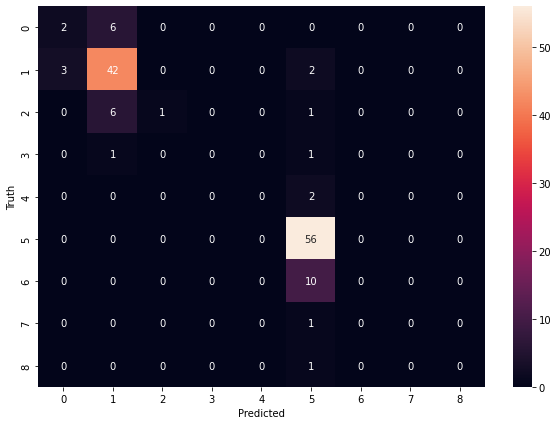

In [ ]:
import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(metrics.confusion_matrix(test_target, model_predictions), annot=True)

plt.xlabel('Predicted')
plt.ylabel('Truth')